In [1]:
import time
from math import sqrt
import matplotlib.pyplot as plt
import random
from env2 import Env
import os
import numpy as np
import torch
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from copy import deepcopy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
class ExperienceDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data

    def __len__(self):
        return len(self.data[0])

    def __getitem__(self, ind):
        return tuple(map(lambda t: t[ind], self.data))

def create_shuffled_dataloader(data, batch_size):
    ds = ExperienceDataset(data)
    return DataLoader(ds, batch_size = batch_size, shuffle = True)

In [3]:
class PolicyNetwork(torch.nn.Module):
    def __init__(self,state_dims, n_actions):
        super(PolicyNetwork, self).__init__()
        self.actor = torch.nn.Sequential(
            torch.nn.Linear(6, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, n_actions),
            torch.nn.Softmax(dim=-1)
        )

    def forward(self, x):
        policy = self.actor(x)

        return policy

class ValueNetwork(torch.nn.Module):
    def __init__(self,state_dims):
        super(ValueNetwork, self).__init__()
        self.critic = torch.nn.Sequential(
            torch.nn.Linear(6, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 1)
        )

    def forward(self, x):
        value = self.critic(x)

        return value

def np_to_tensor(x):
    return torch.tensor(x).to(torch.float32)

    
policy_model = PolicyNetwork(state_dims=6, n_actions = 6)
value_model = ValueNetwork(state_dims=6)

In [4]:
print(policy_model,value_model)
summary(policy_model, input_size=(1, 6))
summary(value_model, input_size=(1, 6))

PolicyNetwork(
  (actor): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=6, bias=True)
    (5): Softmax(dim=-1)
  )
) ValueNetwork(
  (critic): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]             448
              ReLU-2                [-1, 1, 64]               0
            Linear-3                [-1, 1, 32]           2,080
              ReLU-4                [-1, 1, 32]               0
            Linear-5                 [-1, 1, 6]             198
           Softmax

In [5]:
class PPO:
    def __init__(self, state_dim=6, action_dim=6, policy_lr=0.0005, value_lr=0.001, 
                 gamma=0.99, lam=0.95, beta_s=0.01,epsilon_clip=0.2, value_clip=0.4, 
                 epochs=10,batch_size=50,save_path='Models'):
        
        self.policy_net = PolicyNetwork(state_dim, action_dim).to(device)
        self.value_net = ValueNetwork(state_dim).to(device)
        self.policy_optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=policy_lr)
        self.value_optimizer = torch.optim.Adam(self.value_net.parameters(), lr=value_lr)

        self.gamma = gamma
        self.lamda = lam
        self.epsilon_clip = epsilon_clip
        self.value_clip = value_clip
        self.beta_s = beta_s
        self.epochs = epochs
        self.action_dim = action_dim
        self.batch_size = batch_size

        self.env = Env()
        self.env.run()

        self.save_path = save_path
        self.env_name = "auto-docking-iss"

        if not os.path.exists(self.save_path): os.makedirs(self.save_path)
        self.path = str(self.env_name)+'_PPO_'
        self.model_name = os.path.join(self.save_path, self.path)

        self.trajectory = {'states':[],'actions':[], 'rewards':[], 'action_logs':[],
                           'values':[],'done':[]}
        
        self.scores, self.episodes, self.average = [],[],[]
        self.value_loss_mean, self.policy_loss_mean = [], []

    def save(self,episode,score):
        torch.save({
            'actor': self.policy_net.state_dict(),
            'critic': self.value_net.state_dict()
        }, f'./'+ self.model_name + '_' + str(episode) + '_' + str(round(score,4)) + '.pt')

    def load(self,name):
        print(f'./{self.save_path}/{name}')
        try:
            data = torch.load(f'./{self.save_path}/{name}')
            self.policy_net.load_state_dict(data['actor'])
            self.value_net.load_state_dict(data['critic'])
        except Exception as e:
            print(e)

    # Función para visualizar la evolución del entrenamiento
    def plot_model(self, score, episode,num_episodes):
        self.scores.append(score)
        self.episodes.append(episode)
        self.average.append(sum(self.scores[-10:]) / len(self.scores[-10:]))
        if (episode % 10 == 0 and episode > 0) or episode == num_episodes:#str(episode)[-2:] == "00":# much faster than episode % 100
            plt.figure(1,figsize=(18, 9))
            plt.plot(self.episodes, self.scores, 'b')
            plt.plot(self.episodes, self.average, 'r')
            plt.ylabel('Score', fontsize=18)
            plt.xlabel('Steps', fontsize=18)
            try:
                plt.savefig(self.model_name+"scores.png")
            except OSError:
                pass

        return self.average[-1]
    
    def plot_loss(self,episode,num_episodes):        
        if (episode % 10 == 0 and episode > 0) or episode == num_episodes:#str(episode)[-2:] == "00":# much faster than episode % 100
            plt.figure(2,figsize=(18, 9))
            plt.plot(self.episodes, self.policy_loss_mean, 'b')
            plt.plot(self.episodes, self.value_loss_mean, 'r')
            plt.ylabel('Loss', fontsize=18)
            plt.xlabel('Steps', fontsize=18)
            try:
                plt.savefig(self.model_name+"loss.png")
            except OSError:
                pass
    

    #Almacenamiento de todas las variables que definen una transición para PPO
    def collect_trayectory(self,state,action,action_logs,reward,done,value):
        # action_onehot = np.zeros([self.action_dim])
        # action_onehot[action] = 1
        self.trajectory['states'].append(state)
        self.trajectory['actions'].append(action)
        self.trajectory['rewards'].append(reward)
        self.trajectory['values'].append(value)
        self.trajectory['action_logs'].append(action_logs)
        self.trajectory['done'].append(done)
    
    def clear_trayectory(self):
        for key in self.trajectory.keys():
            self.trajectory[key].clear()
    
    def select_action(self,state):
        action_probs = self.policy_net(state).squeeze().detach()
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample()
        action_log_probs = dist.log_prob(action)
        
        return action.item(),action_log_probs,dist.entropy().item()

    
    def generalized_advantage_estimation(self,next_state):
        advantages = np.zeros_like(self.trajectory['rewards'])
        last_gae_lambda = 0
        self.trajectory['values'].append(self.value_net(next_state).squeeze().detach())

        for t in reversed(range(len(self.trajectory['rewards']))):
            delta = self.trajectory['rewards'][t]+ self.gamma * self.trajectory['values'][t + 1].item() - self.trajectory['values'][t].item()
            advantages[t] = last_gae_lambda = delta + self.gamma * self.lamda * last_gae_lambda
        
        return np_to_tensor(advantages)


    def learn_from_episode_trajectory(self,next_state):
        self.policy_net.train()
        self.value_net.train()

        # to_torch_tensor = lambda t: torch.stack(t).to(device).detach()

        states = deepcopy(self.trajectory['states'])
        actions = deepcopy(self.trajectory['actions'])
        # rewards = deepcopy(self.trajectory['rewards'])
        values = deepcopy(self.trajectory['values'])
        action_logs = deepcopy(self.trajectory['action_logs'])
        # done = deepcopy(self.trajectory['done'])

        advantages = self.generalized_advantage_estimation(next_state).to(device)

        # prepare dataloader for policy phase training
        dl = create_shuffled_dataloader([states, actions, action_logs, advantages, values], self.batch_size)

        policy_loss_array = []
        value_loss_array = []

        for i in range(self.epochs):
            for states, actions, action_log, advantages, values in dl:
                #Update policy_net
                new_action_probs = self.policy_net(states).squeeze()
                dist = torch.distributions.Categorical(new_action_probs)

                # print("")
                # print(actions)
                # print(new_action_probs)
                new_action_logs = dist.log_prob(actions)
                entropy = dist.entropy()

                # compute PPO-Clip
                ratios = torch.exp(new_action_logs - action_log)
                surr1 = ratios * advantages
                surr2 = ratios.clamp(1 - self.epsilon_clip, 1 + self.epsilon_clip) * advantages
                policy_loss = -torch.mean(torch.min(surr1, surr2) - self.beta_s * entropy)
                policy_loss_array.append(policy_loss.detach().numpy())

                self.policy_optimizer.zero_grad() # Clean gradients
                policy_loss.mean().backward() # Compute gradients
                self.policy_optimizer.step() #Update weights

                #Update value_net
                new_values = self.value_net(states).squeeze()
                value_clipped = values + (new_values - values).clamp(-self.value_clip, self.value_clip)
                value_loss_1 = (value_clipped.flatten() - advantages) ** 2
                value_loss_2 = (values.flatten() - advantages) ** 2
                value_loss = torch.mean(torch.max(value_loss_1, value_loss_2))
                value_loss_array.append(value_loss.detach().numpy())

                self.value_optimizer.zero_grad() # Clean gradients
                value_loss.backward() # Compute gradients 

        self.value_loss_mean.append(sum(value_loss_array)/self.epochs)
        self.policy_loss_mean.append(sum(policy_loss_array)/self.epochs)

        print(f"\n Mean Policy loss: {self.value_loss_mean[-1]:.4f}. Mean Value loss: {self.policy_loss_mean[-1]:.4f}")
        
        self.policy_net.eval()
        self.value_net.eval()


    # Función para resetear el entorno tras acabar trayectoria
    def reset(self):
        state = self.env.reset()
        return np_to_tensor(self.process_state(state))
    
     # Función para interacción agente-entorno
    def step(self, action):
        next_state, reward, done = self.env.step(action)
        next_state = self.process_state(next_state)
        return np_to_tensor(next_state), reward, done

    def process_state(self,state):
        state_processed = np.array(state)
        state_processed[:3] = state_processed[:3] / 40 # Position array
        return state_processed
    
    def train(self,num_episodes=200,max_steps=200):
        average = 0
        self.policy_net.eval()
        self.value_net.eval()

        max_score_average = -5000

        for episode in range(1,num_episodes+1):
            self.clear_trayectory()

            state = self.reset()
            score = 0

            SAVING = ""

            for step in range(1,max_steps+1):
                
                action_probs = self.policy_net(state).squeeze().detach()
                dist = torch.distributions.Categorical(action_probs)
                action = dist.sample()
                action_log = dist.log_prob(action)

                value = self.value_net(state).squeeze().detach()
                
                next_state,reward,done = self.step(action.item())    
                self.collect_trayectory(state,action,action_log,reward,done,value)

                state = next_state

                score += reward

                print(f'\rSteps: {step}/{max_steps}. Action: {action}. Reward/Value: {round(reward,2)}/{round(value.item(),4)}. Done: {done}', end='', flush=True)

                if done:
                    break
                
                time.sleep(1)

            self.learn_from_episode_trajectory(next_state)
            self.clear_trayectory()

            average = self.plot_model(score, episode,num_episodes)
            self.plot_loss(episode,num_episodes)
            
            if average >= max_score_average and episode > 5:
                max_score_average = average
                self.save(episode,score)
                SAVING = "SAVING"
            elif episode % 10 == 0:
                self.save(episode,score)
                SAVING = "SAVING"
            else:
                SAVING = ""
            
            print(f"Episode: {episode}/{num_episodes}, score/average: {score:.4f}/{average:.4f} {SAVING}\n")


        # close environemnt when finish training
        self.save(episode,score)

    def test(self,max_steps):
        self.policy_net.eval()
        self.value_net.eval()

        self.clear_trayectory()
        state = self.reset()
        score = 0

        start = time.time()
        end = time.time()
        step = 0

        while True:
            end = time.time()
            if end - start >= 1.0:
                step += 1
                action = np.argmax(self.policy_net(state).squeeze().detach().numpy())
                value = self.value_net(state).squeeze().detach()
                
                next_state,reward,done = self.step(action)    

                state = next_state

                score += reward

                print(f'\rSteps: {step}/{max_steps}. Action: {action}. Score/Value: {round(score,2)}/{round(value.item(),4)}. Done: {done}', end='', flush=True)
                start = time.time()

            if self.env.done:
                break

        state_end = self.env.get_state()
        
        print(f'\nNext state: {state_end}')


In [6]:
agent = PPO(save_path='Models4')

(20354) wsgi starting up on http://127.0.0.1:5000


(20354) accepted ('127.0.0.1', 56768)
(20354) accepted ('127.0.0.1', 56778)
127.0.0.1 - - [07/Aug/2024 14:17:38] "GET / HTTP/1.1" 304 242 0.005255
127.0.0.1 - - [07/Aug/2024 14:17:38] "GET /css/normalize.css HTTP/1.1" 304 201 0.001062
(20354) accepted ('127.0.0.1', 56790)
(20354) accepted ('127.0.0.1', 56794)
(20354) accepted ('127.0.0.1', 56800)
(20354) accepted ('127.0.0.1', 56810)
(20354) accepted ('127.0.0.1', 56816)
(20354) accepted ('127.0.0.1', 56826)
127.0.0.1 - - [07/Aug/2024 14:17:38] "GET /css/layout.css HTTP/1.1" 304 198 0.000818
127.0.0.1 - - [07/Aug/2024 14:17:38] "GET /js/three/WebGL.js HTTP/1.1" 304 196 0.000627
127.0.0.1 - - [07/Aug/2024 14:17:38] "GET /js/three/GLTFLoader.js HTTP/1.1" 304 201 0.000536
127.0.0.1 - - [07/Aug/2024 14:17:38] "GET /js/three/CSS2DRenderer.js HTTP/1.1" 304 204 0.000588
127.0.0.1 - - [07/Aug/2024 14:17:38] "GET /js/three/three.js HTTP/1.1" 304 196 0.000472
127.0.0.1 - - [07/Aug/2024 14:17:38] "GET /js/gsap3/gsap.js HTTP/1.1" 304 195 0.000450


Reset
Steps: 53/200. Action: 0. Reward/Value: -0.55/-0.0531. Done: -1
 Mean Policy loss: 6.5049. Mean Value loss: -1.3894
Episode: 1/200, score/average: 3.1000/3.1000 

Reset
Steps: 200/200. Action: 5. Reward/Value: -0.55/-0.0516. Done: 0
 Mean Policy loss: 104.4440. Mean Value loss: 16.6911
Episode: 2/200, score/average: -57.1000/-27.0000 

Reset
Steps: 193/200. Action: 0. Reward/Value: -0.55/-0.0563. Done: -1
 Mean Policy loss: 107.8792. Mean Value loss: 4.3078
Episode: 3/200, score/average: -10.0500/-21.3500 

Reset
Steps: 45/200. Action: 5. Reward/Value: -0.3/-0.0493. Done: -1
 Mean Policy loss: 2.0956. Mean Value loss: -0.8643
Episode: 4/200, score/average: 2.2000/-15.4625 

Reset
Steps: 80/200. Action: 2. Reward/Value: -0.9/-0.0571. Done: 10
 Mean Policy loss: 81.0218. Mean Value loss: -7.3549
Episode: 5/200, score/average: 15.2500/-9.3200 

Reset
Steps: 59/200. Action: 4. Reward/Value: -0.3/-0.066. Done: -1
 Mean Policy loss: 6.8868. Mean Value loss: -3.1356
Episode: 6/200, scor

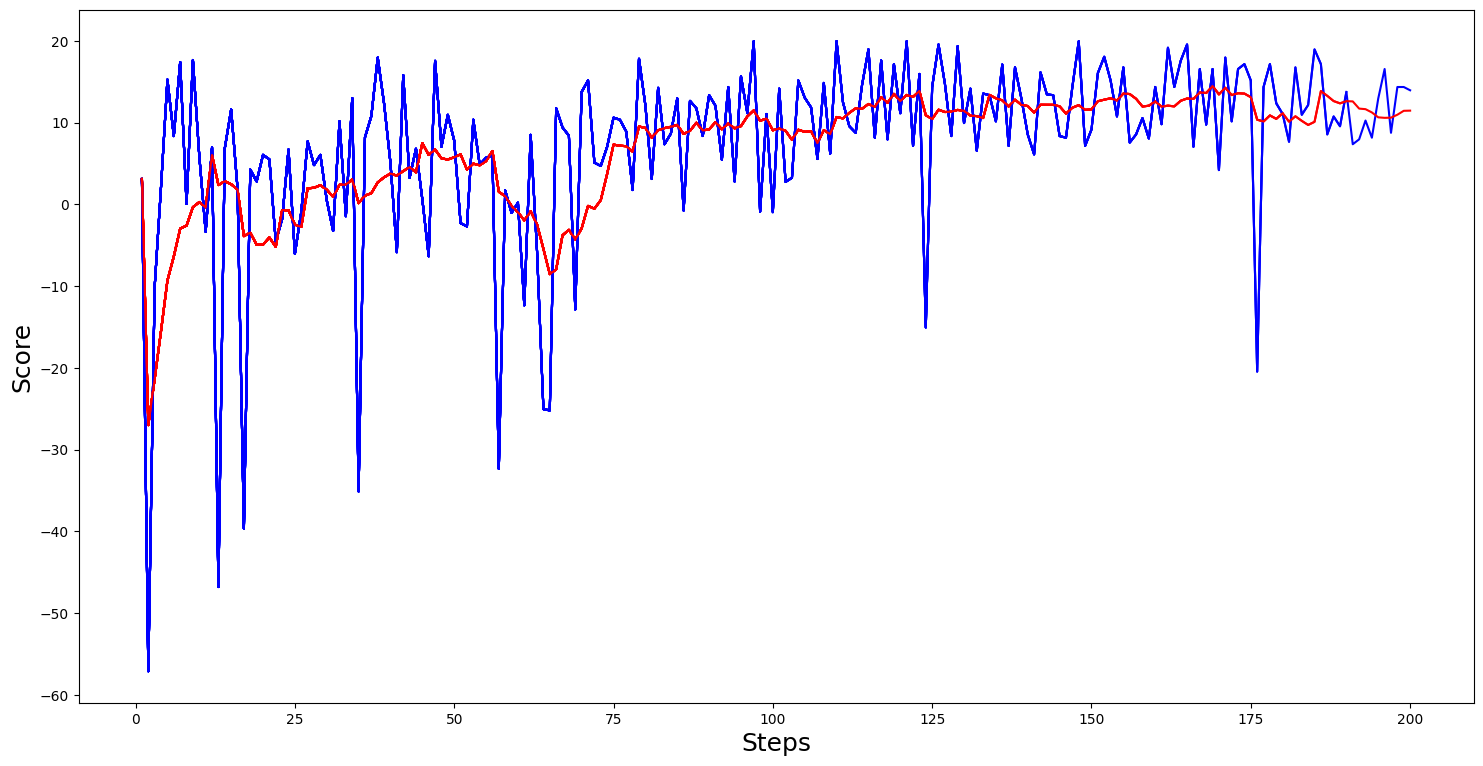

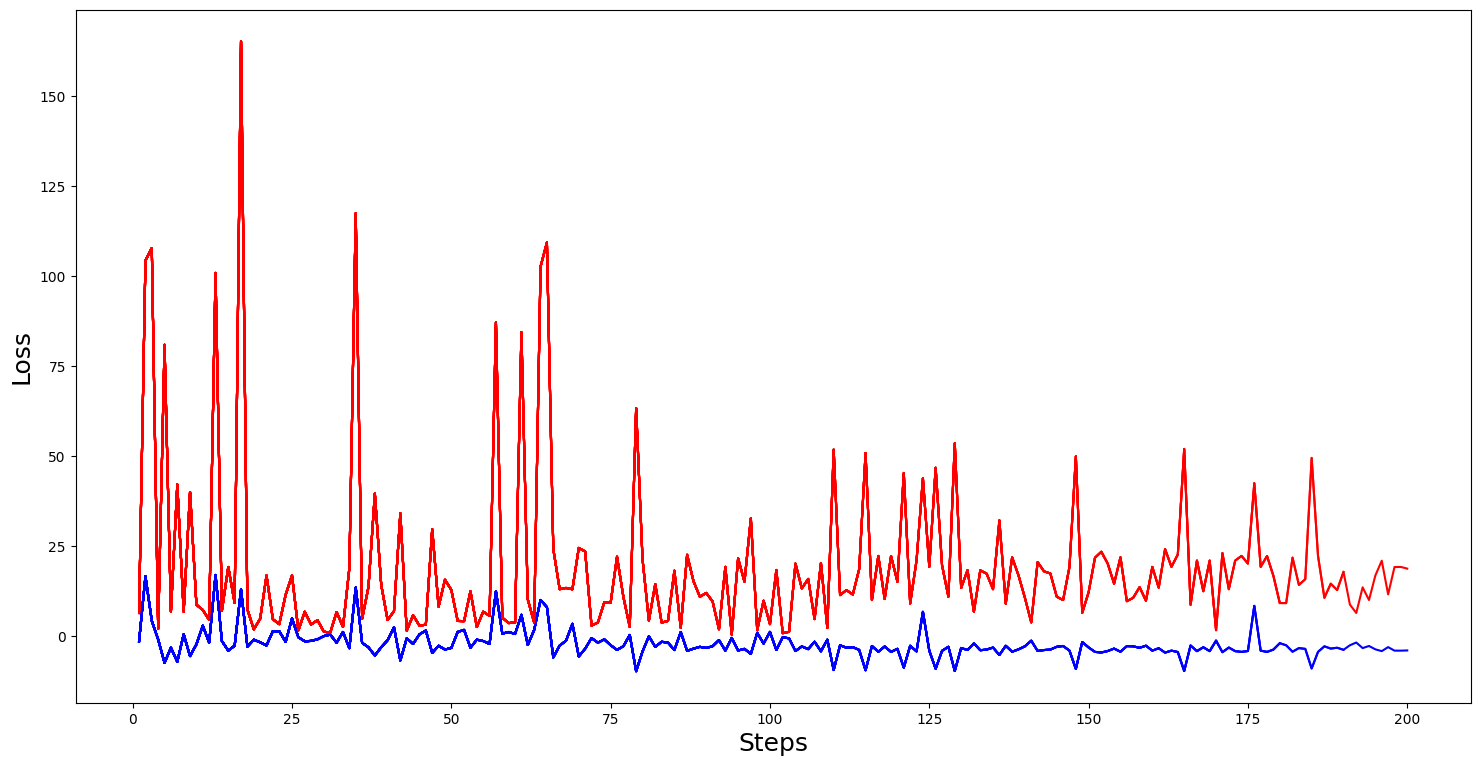

In [7]:
agent.train(num_episodes=200,max_steps=200)

In [14]:
agent.load("auto-docking-iss_PPO__101_14.15.pt")


./Models4/auto-docking-iss_PPO__101_14.15.pt


In [15]:
agent.test(500)

Reset
Steps: 47/500. Action: 1. Score/Value: 17.95/-0.0638. Done: 0
Next state: [-0.10060000002610536, -1.9059, 1.3578, -0.09402245256671271, 0.0, 0.0]
